# Survival Analysis

Mining Excavator dataset case study

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nestor import keyword as kex
# from mlp.tree import node_adj_mat, tag_network, tag_df_network
# from mlp.plot import hv_net
# from bokeh.palettes import Viridis10, Category10_6
# import networkx as nx

In [ ]:
import re
from tqdm import tqdm_notebook, tqdm


In [ ]:
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

set_style()

In [ ]:
import holoviews as hv
hv.extension('bokeh')

%opts Graph [width=600 height=400]

In [16]:
from pathlib import Path
data_dir = Path('data')/'mine_data'

# merge and cleanse NLP-containing columns of the data
nlp_select = kex.NLPSelect(columns = ['OriginalShorttext'])
raw_text = nlp_select.transform(df)

FileNotFoundError: File b'data/mine_data/mine_raw.csv' does not exist

In [18]:
# merge and cleanse NLP-containing columns of the data
gs_nlp_select = kex.NLPSelect(columns = ['OriginalShorttext'])
raw_text = gs_nlp_select.transform(df)

NameError: name 'kex' is not defined

### Build Vocab

In [17]:
study_fname = data_dir/'vocab_study'/'vocab_study_results.csv'

tex = kex.TokenExtractor()
toks = tex.fit_transform(raw_text)

tex2 = kex.TokenExtractor(ngram_range=(2, 2))  # new extractor (note 2-gram)
# define rules
NE_map = {'I I': 'I',  # two items makes one new item
          'I P': 'P I', 'I S': 'S I', 'P I': 'P I', 'S I': 'S I',  # order-free 
          'P P': 'X', 'P S': 'X', 'S P': 'X', 'S S': 'X'}  # redundancies
NE_types = 'IPSUX'
names=[f'{i}min' for i in range(10,70,10)]
files = sorted((data_dir/'vocab_study').glob('mine_public_raw_1Gram_[1-6]0mins.csv'))
if not study_fname.is_file():
    study_df = pd.DataFrame(index=df.index)
    for n,file in enumerate(files):
        print(str(file))
        vocab = kex.generate_vocabulary_df(tex, init=file)
        # do 1-grams
        tags_df = kex.tag_extractor(tex, raw_text, vocab_df=vocab)
        
#         ######

#         ########
        
        # do statistics
        tag_pct, tag_comp, tag_empt = kex._get_tag_completeness(tags_df)
        study_df[names[n]] = tag_pct
    study_df.to_csv(study_fname)
else: 
    study_df = pd.read_csv(study_fname, index_col=0)

study_df.head()



FileNotFoundError: [Errno 2] No such file or directory: 'data/mine_data/vocab_study/vocab_study_results.csv'

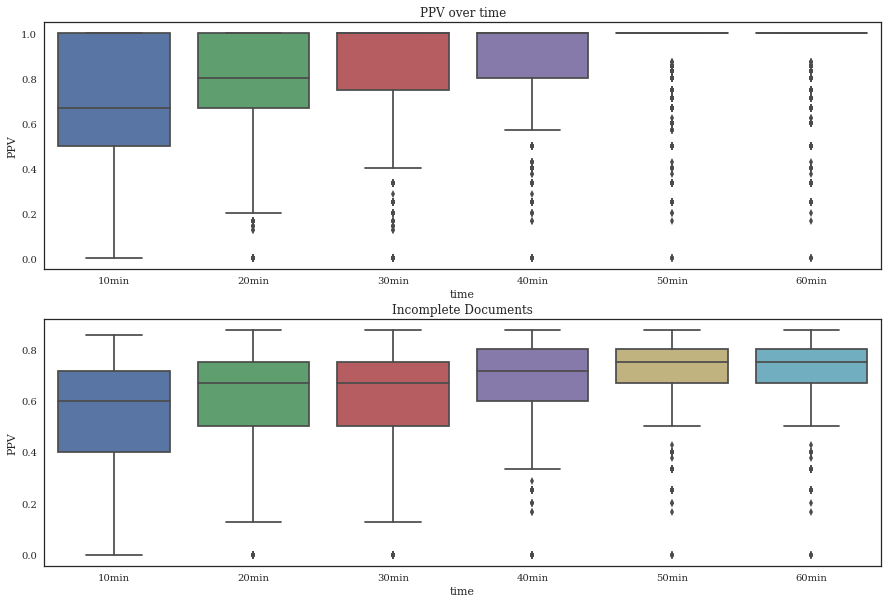

In [10]:
study_long = pd.melt(study_df, var_name="time", value_name='PPV').dropna()
study_long['time_val'] = study_long.time.str.replace('min','').astype(float)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(211)
ax.set_title('PPV over time')
sns.boxplot("time", y="PPV", data=study_long, ax=ax)
ax2 = fig.add_subplot(212)
ax2.set_title('Incomplete Documents')
sns.boxplot("time", y="PPV", data=study_long[study_long.PPV!=1], ax=ax2)

# sns.violinplot()

In [11]:
#now the good stuff
vocab_fname = data_dir/'vocab_study'/'mine_public_raw_1Gram_1grams-60mins-2grams-20mins.csv'
vocab = kex.generate_vocabulary_df(tex, init=vocab_fname)
tags_df = kex.tag_extractor(tex, raw_text, vocab_df=vocab)

intialized successfully!
intialized successfully!


In [12]:
replaced_text = kex.token_to_alias(raw_text, vocab)  # raw_text, with token-->alias replacement
toks2 = tex2.fit_transform(replaced_text)

#make 2-gram dictionary
vocab2_fname = data_dir/'vocab_study'/'mine_public_raw_nGram_1grams-60mins-2grams-20mins.csv'
vocab2 = kex.generate_vocabulary_df(tex2, init=vocab2_fname)

# extract 2-gram tags from cleaned text
tags2_df = kex.tag_extractor(tex2, replaced_text, vocab_df=vocab2)

## experimental: we need [item_item action] 2-grams, so let's use 2-gram Items for a 3rd pass...
# tex3 = kex.TokenExtractor(ngram_range(2,2))
# replaced_text2 = kex.token_to_alias(raw_text, vocab.join(vocab2))

intialized successfully!
intialized successfully!


In [13]:
## experimental: we need [item_item action] 2-grams, so let's use 2-gram Items for a 3rd pass...
tex3 = kex.TokenExtractor(ngram_range=(1,2))
# mask = (vocab2.NE=='I') & (vocab2.alias!='')
mask = (np.isin(vocab2.NE, ['I', 'P', 'S'])) & (vocab2.alias!='')
vocab_combo = pd.concat([vocab, vocab2[mask]])
vocab_combo['score'] = 0

# keep just in case of duplicates
vocab_combo = vocab_combo.reset_index().drop_duplicates(subset=['tokens']).set_index('tokens')

replaced_text2 = kex.token_to_alias(replaced_text, vocab_combo)
# print(replaced_text2)
toks3 = tex3.fit_transform(replaced_text2)
# print(toks3)
# define rules
NE_map = {'I I': 'I',  # two items makes one new item
          'I P': 'P I', 'I S': 'S I', 'P I': 'P I', 'S I': 'S I',  # order-free 
          'P P': 'X', 'P S': 'X', 'S P': 'X', 'S S': 'X'}  # redundancies
NE_types = 'IPSUX'

#make 2-gram dictionary
vocab3 = kex.generate_vocabulary_df(tex3)
vocab3 = kex.ngram_automatch(vocab_combo, vocab3, NE_types, NE_map)

# extract 2-gram tags from cleaned text
tags3_df = kex.tag_extractor(tex3, replaced_text2, vocab_df=vocab3)

intialized successfully!


In [14]:
# merge 1 and 2-grams?
# tag_df = tags_df.join(tags3_df.drop(axis='columns', labels=tags_df.columns.levels[1].tolist(), level=1))
# relation_df = tag_df.loc[:, ['P I', 'S I']]

tag_df = tags_df.copy()

tags_read = kex._get_readable_tag_df(tag_df)
tag_df = tag_df.loc[:, ['I', 'P', 'S', 'U', 'X', 'NA']]    
    

### Extracted Keywords

Docs have at most 6 tokens (95th percentile)


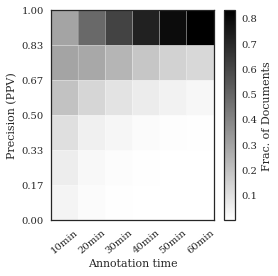

In [15]:
import matplotlib.cm as cm
nbins = int(np.percentile(tag_df.sum(axis=1), 95))
print(f'Docs have at most {nbins} tokens (95th percentile)')
H, x_edge, y_edge = np.histogram2d(study_long.time_val, study_long.PPV, bins=[6,nbins], normed=False)
H = H/len(df)
X, Y = np.meshgrid(x_edge, y_edge)
# city.plot(ax=ax, color='xkcd:slate')
# pcm = ax.pcolormesh(X, Y, H)
import matplotlib.colors as colors
fig, ax = plt.subplots(1, 1, figsize=(4,4), sharey=True)
# plt.figure()

# pcm = ax[0].pcolor(X, Y, H.T ,cmap=cm.gray_r, 
#                 norm=colors.LogNorm(vmin=H.min(), 
#                                     vmax=H.max()),
#                edgecolors='white', linewidths=.2,)
ppv_labels = np.linspace(0,1,nbins+1)
# ax[0].set_yticks(ppv_labels, [f'{i:.2f}' for i in ppv_labels])
# ax[0].set_xticks(x_edge+50/12.)
# ax[0].set_xticklabels( names, rotation=40)
# # plt.Axes.set_xticklabels()
# ax[0].set_xlim(10,60)
# ax[0].set_xlabel('Annotation time')
ax.set_ylabel('Precision (PPV)')
# plt.title('Mean Calls/Day')
# fig.colorbar(pcm, ax=ax)

pcm = ax.pcolor(X, Y, H.T ,cmap=cm.gray_r, 
#                 norm=colors.LogNorm(vmin=H.min(), 
#                                     vmax=H.max()),
               edgecolors='white', linewidths=.2,)
ppv_labels = np.linspace(0,1,nbins+1)
plt.yticks(ppv_labels, [f'{i:.2f}' for i in ppv_labels])
plt.xticks(x_edge+50/12., names, rotation=40)
ax.set_xlim(10,60)
ax.set_xlabel('Annotation time')
# ax[1].set_ylabel('Precision (PPV)')
# plt.title('Mean Calls/Day')
fig.colorbar(pcm, ax=ax, label='Frac. of Documents')
plt.tight_layout()

In [16]:
tags_read.join(df[['OriginalShorttext']]).sample(10)

,I,P,S,U,X,OriginalShorttext
2894,"grease, pipe, rotor",leak,replace,,,REPLACE LEAKING GREASE PIPE(rotor)
4586,"cab, door, latch",,repair,,,REPAIR CAB DOOR LATCH.
5258,air,blowing,,hot,,A/C BLOWING HOT AIR
5387,"right_hand, belt",,replace,,,Replace RH A/C belt
2827,roller,,,load,,GREASED LOAD ROLLER
1,"bucket, cylinder",leak,,,,L/H BUCKET CYL LEAKING.
3072,"bucket, lube, line, shd",,replace,,,Replace bucket lube line on SHD24
1972,"hose, hyd",blown,,,,IREPLACE BLOWN HYD. HOSE RYCO #
4752,"wiper, blade",,,,,Refit wiper blade
1172,"fan, belt",broken,,,,Broken fan belt


In [17]:
# how many instances of each keyword class are there?
print('named entities: ')
print('I\tItem\nP\tProblem\nS\tSolution\nR\tRedundant')
print('U\tUnknown\nX\tStop Word')
print('total tokens: ', vocab.NE.notna().sum())
print('total tags: ', vocab.groupby("NE").nunique().alias.sum())
vocab.groupby("NE").nunique()

named entities: 
I	Item
P	Problem
S	Solution
R	Redundant
U	Unknown
X	Stop Word
total tokens:  1767
total tags:  492


,NE,alias,notes,score
NE,,,,
,1,3,2,766
I,1,317,19,585
P,1,53,6,119
S,1,42,2,95
U,1,68,57,92
X,1,9,1,9


Tag completeness: 0.94 +/- 0.13
Complete Docs: 4444, or 81.02%
Empty Docs: 48, or 0.88%


/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'precision (PPV)')

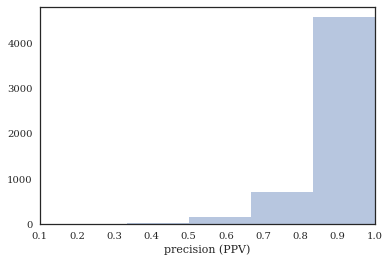

In [19]:
# tag-completeness of work-orders?
tag_pct, tag_comp, tag_empt = kex._get_tag_completeness(tag_df)

# with sns.axes_style('ticks') as style:
sns.distplot(tag_pct.dropna(), 
             kde=False, bins=nbins, 
             kde_kws={'cut':0})
plt.xlim(0.1, 1.0)
plt.xlabel('precision (PPV)')


/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


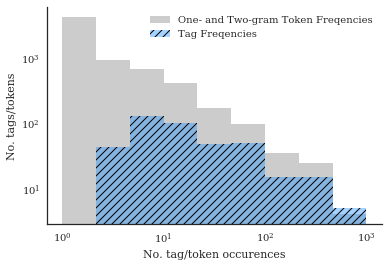

In [20]:


cts = (tex._model.transform(raw_text)>0.).astype(int).toarray().sum(axis=0)
cts2 = (tex3._model.transform(replaced_text2)>0.).astype(int).toarray().sum(axis=0)

sns.distplot(np.concatenate((cts, cts2)), 
             bins=np.logspace(0,3,10),
#              bins=np.linspace(0,1500,10),
             norm_hist=False, 
             kde=False, 
             label='One- and Two-gram Token Freqencies',
             hist_kws={'color':'grey'})
# cts
sns.distplot(tag_df[['I', 'P', 'S']].sum(), 
             bins=np.logspace(0,3,10),
#              bins=np.linspace(0,1500,10),
             norm_hist=False, 
             kde=False, 
             label='Tag Freqencies', 
             hist_kws={'hatch':'///', 'color':'dodgerblue'})

plt.yscale('log')
plt.xscale('log')
tag_df.sum().shape, cts.shape
plt.legend()
plt.xlabel('No. tag/token occurences')
plt.ylabel('No. tags/tokens')
sns.despine()

# WORK BELOW HERE
## Survival Analysis

### Rules-Based

In [21]:

df_clean = pd.read_csv(data_dir/'mine_clean.csv')
df_clean['SuspSugg'] = pd.to_numeric(df_clean['SuspSugg'], errors='coerce')
df_clean.dropna(subset=['RunningTime', 'SuspSugg'], inplace=True)
df_clean['BscStartDate'] = pd.to_datetime(df_clean.BscStartDate)
df_clean.shape

(5288, 17)

In [22]:
df_clean.sort_values('BscStartDate').head(10)

,BscStartDate,Asset,OriginalShorttext,PMType,Cost,RunningTime,MajorSystem,Part,Action,Variant,FM,Location,Comments,FuncLocation,SuspSugg,Rule,Unnamed: 16
8,2001-07-19,B,REPLACE LIP,PM01,1251.52,7.0,Bucket,NaN,Replace,2V,NaN,NaN,NaN,Bucket,0.0,Rule_1_3_78_383_384,NaN
1820,2001-09-01,B,OIL LEAK L/H TRACK TENSIONER.,PM01,0.00,3.0,Hydraulic System,Track,Minor Maint,18,Leak,Left,NaN,Power Train - Transmission,0.0,Rule_1_3_52_289_347_425_500,NaN
1821,2001-09-04,B,BAD SOS METAL IN OIL,PM01,0.00,3.0,Hydraulic System,Slew Gearbox,NaN,NaN,Contamination,NaN,NaN,Sprocket/Drive Compartment Right,0.0,Rule_1_3_52_303_409,NaN
5253,2001-09-05,B,REPLACE AIRCONDITIONER BELTS,PM01,0.00,23.0,NaN,Air Conditioning,Replace,2V,NaN,NaN,NaN,Air Conditioning System,0.0,Rule_1_3_224_227_383_384,NaN
3701,2001-09-05,B,REPLACE CLAMPS ON CLAM PIPES,PM01,0.00,28.0,NaN,Mount,Replace,2V,NaN,NaN,NaN,Oil - Hydraulic,0.0,Rule_1_3_92_181_383_384,NaN
1167,2001-09-05,B,REPLACE RHS FAN BELT TENSIONER PULLEY,PM01,82.09,0.0,NaN,Fan,Minor Maint_Replace,2V,NaN,Right,NaN,+Cooling System,0.0,Rule_1_3_125_347_383_384_509,NaN
1168,2001-09-11,B,replace fan belt,PM01,0.00,6.0,NaN,Fan,Replace,2V,NaN,NaN,NaN,+Cooling System,0.0,Rule_1_3_125_383_384,NaN
644,2001-09-15,B,replace heads on lhs eng,PM01,0.00,33.0,Engine,NaN,Replace,2V,NaN,Left,NaN,Engine Left Cylinder Heads,0.0,Rule_1_3_25_383_384_499,NaN
4583,2001-09-26,B,REPAIR CABIN DOOR FALLING OFF.,PM01,0.00,27.0,NaN,Drivers Cabin,Repair,1,NaN,NaN,NaN,Operators Cabin,0.0,Rule_1_3_251_284_357,NaN
9,2001-10-01,B,rebuild lip #3,PM01,0.00,74.0,Bucket,NaN,Repair,5,NaN,NaN,NaN,Bucket Clam (Lip),0.0,Rule_1_3_78_362,NaN


0.060 0.833
transform: β=0.83	η=16.73


lambda_    0.06±0.0033
rho_        0.83±0.026
dtype: object

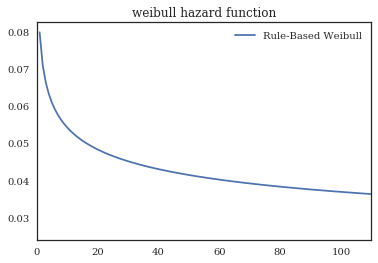

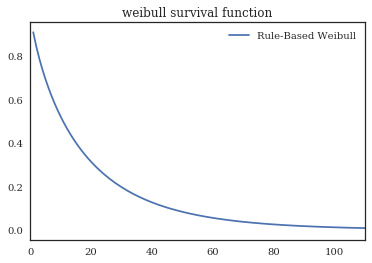

In [23]:
from lifelines import WeibullFitter, ExponentialFitter, KaplanMeierFitter
mask = (df_clean.MajorSystem =='Bucket')
# mask=df_clean.index
def mask_to_ETclean(df_clean, mask, fill_null=1.):
    filter_df = df_clean.loc[mask]
    g = filter_df.sort_values('BscStartDate').groupby('Asset')
    T = g['BscStartDate'].transform(pd.Series.diff).dt.days
#     T.loc[(T<=0.)|(T.isna())] = fill_null
    E = (~filter_df['SuspSugg'].astype(bool)).astype(int)
    return T.loc[~((T<=0.)|(T.isna()))], E.loc[~((T<=0.)|(T.isna()))]

T, E = mask_to_ETclean(df_clean, mask)
wf = WeibullFitter()
wf.fit(T, E, label='Rule-Based Weibull')
print('{:.3f}'.format(wf.lambda_), '{:.3f}'.format(wf.rho_))
# wf.print_summary()
wf.hazard_.plot()
plt.title('weibull hazard function')
plt.xlim(0,110)

wf.survival_function_.plot()
plt.xlim(0,110)
plt.title('weibull survival function')
print(f'transform: β={wf.rho_:.2f}\tη={1/wf.lambda_:.2f}')
# wf._compute_standard_errors()
to_bounds = lambda row:'±'.join([f'{i:.2g}' for i in row])
wf.summary.iloc[:,:2].apply(to_bounds, 1)

In [24]:
import math


def to_precision(x,p):
    """
    returns a string representation of x formatted with a precision of p

    Based on the webkit javascript implementation taken from here:
    https://code.google.com/p/webkit-mirror/source/browse/JavaScriptCore/kjs/number_object.cpp
    """

    x = float(x)

    if x == 0.:
        return "0." + "0"*(p-1)

    out = []

    if x < 0:
        out.append("-")
        x = -x

    e = int(math.log10(x))
    tens = math.pow(10, e - p + 1)
    n = math.floor(x/tens)

    if n < math.pow(10, p - 1):
        e = e -1
        tens = math.pow(10, e - p+1)
        n = math.floor(x / tens)

    if abs((n + 1.) * tens - x) <= abs(n * tens -x):
        n = n + 1

    if n >= math.pow(10,p):
        n = n / 10.
        e = e + 1

    m = "%.*g" % (p, n)

    if e < -2 or e >= p:
        out.append(m[0])
        if p > 1:
            out.append(".")
            out.extend(m[1:p])
        out.append('e')
        if e > 0:
            out.append("+")
        out.append(str(e))
    elif e == (p -1):
        out.append(m)
    elif e >= 0:
        out.append(m[:e+1])
        if e+1 < len(m):
            out.append(".")
            out.extend(m[e+1:])
    else:
        out.append("0.")
        out.extend(["0"]*-(e+1))
        out.append(m)

    return "".join(out)

def query_experiment(name, df, df_clean, rule, tag, multi_tag):
    
    def mask_to_ETclean(df_clean, mask, fill_null=1.):
        filter_df = df_clean.loc[mask]
        g = filter_df.sort_values('BscStartDate').groupby('Asset')
        T = g['BscStartDate'].transform(pd.Series.diff).dt.days
        E = (~filter_df['SuspSugg'].astype(bool)).astype(int)
        return T.loc[~((T<=0.)|(T.isna()))], E.loc[~((T<=0.)|(T.isna()))]
    
    def mask_to_ETraw(df_clean, mask, fill_null=1.):
        filter_df = df_clean.loc[mask]
        g = filter_df.sort_values('BscStartDate').groupby('Asset')
        T = g['BscStartDate'].transform(pd.Series.diff).dt.days
        T_defined = (T>0.)|T.notna()
        T = T[T_defined]
        # assume censored when parts replaced (changeout)
        E = (~(tag_df.S.changeout>0)).astype(int)[mask]
        E = E[T_defined]
        return T.loc[~((T<=0.)|(T.isna()))], E.loc[~((T<=0.)|(T.isna()))]
    
    experiment = {
        'rules-based': {
            'query': rule,
            'func': mask_to_ETclean,
            'mask': (df_clean.MajorSystem == rule),
            'data': df_clean
        },
        'single-tag': {
            'query': tag,
            'func': mask_to_ETraw,
            'mask': tag_df.I[tag].sum(axis=1)>0,
            'data': df
        },
        'multi-tag': {
            'query': multi_tag,
            'func': mask_to_ETraw,
            'mask': tag_df.I[multi_tag].sum(axis=1)>0,
            'data': df
        }
    }
    results = {
       ('query', 'text/tag'): [],
#        ('Weibull Params', r'$\lambda$'): [],
       ('Weibull Params', r'$\beta$'): [],
       ('Weibull Params', '$\eta$'): [],
       ('MTTF', 'Weib.'): [],
       ('MTTF', 'K-M'): []
       }
    idx = []
    
    for key, info in experiment.items():
        idx += [key]
        results[('query','text/tag')] += [info['query']]
        print('{}: {}'.format(key, info['query']))
        info['T'], info['E'] = info['func'](info['data'], info['mask'])
        wf = WeibullFitter()
        wf.fit(info['T'], info['E'], label=f'{key} weibull')
        
        to_bounds = lambda row:'$\pm$'.join([to_precision(row[0],2),
                                             to_precision(row[1],1)])
        
        params = wf.summary.T.iloc[:2]
        params['eta_'] = [1/params.lambda_['coef'],  # err. propagation
                          (params.lambda_['se(coef)']/params.lambda_['coef']**2)]
        params = params.T.apply(to_bounds, 1)
        
        results[('Weibull Params', r'$\eta$')] += [params['eta_']]
        results[('Weibull Params', r'$\beta$')] += [params['rho_']]
                                             
        print('\tWeibull Params:\n',
              '\t\tη = {}\t'.format(params['eta_']), 
              'β = {}'.format(params['rho_']))
        
        kmf = KaplanMeierFitter()
        kmf.fit(info["T"], event_observed=info['E'], label=f'{key} kaplan-meier')
        results[('MTTF','Weib.')] += [to_precision(wf.median_,3)]
        results[('MTTF','K-M')] += [to_precision(kmf.median_,3)]
        print(f'\tMTTF: \n\t\tWeib \t'+to_precision(wf.median_,3)+\
              '\n\t\tKM \t'+to_precision(kmf.median_,3))
        info['kmf'] = kmf
        info['wf'] = wf
    return experiment, pd.DataFrame(results, index=pd.Index(idx, name=name))

In [25]:
bucket_exp, bucket_res = query_experiment('Bucket', df, df_clean,
                                          'Bucket',
                                          ['bucket'],
                                          ['bucket', 'tooth', 'lip', 'pin'])


rules-based: Bucket
	Weibull Params:
 		η = 17$\pm$0.9	 β = 0.83$\pm$0.03
	MTTF: 
		Weib 	10.8
		KM 	9.00
single-tag: ['bucket']
	Weibull Params:
 		η = 27$\pm$2	 β = 0.83$\pm$0.03
	MTTF: 
		Weib 	17.1
		KM 	15.0
multi-tag: ['bucket', 'tooth', 'lip', 'pin']
	Weibull Params:
 		η = 16$\pm$0.9	 β = 0.82$\pm$0.02
	MTTF: 
		Weib 	10.5
		KM 	9.00


In [26]:
# tags = (np.exp(tag_similarity['hyd'])/(np.exp(tag_similarity).sum())).iloc[:200].sort_values(ascending=False)[:12].index.tolist()
tags = ['hyd', 'hose', 'pump', 'compressor']
hyd_exp, hyd_res = query_experiment('Hydraulic System', df, df_clean,
                                    'Hydraulic System',
                                    ['hyd'],
                                    tags)
# print(hyd_res.to_latex(escape=False, column_format='lcccc', multicolumn_format='c'))

rules-based: Hydraulic System
	Weibull Params:
 		η = 14$\pm$0.6	 β = 0.86$\pm$0.02
	MTTF: 
		Weib 	9.07
		KM 	8.00
single-tag: ['hyd']
	Weibull Params:
 		η = 36$\pm$3	 β = 0.89$\pm$0.04
	MTTF: 
		Weib 	24.1
		KM 	25.0
multi-tag: ['hyd', 'hose', 'pump', 'compressor']
	Weibull Params:
 		η = 15$\pm$0.7	 β = 0.89$\pm$0.02
	MTTF: 
		Weib 	9.74
		KM 	9.00


In [27]:
eng_exp, eng_res = query_experiment('Engine', df, df_clean,
                                    'Engine',
                                    ['engine'],
                                    ['engine', 'filter', 'fan'])
# print(eng_res.to_latex(escape=False, column_format='lcccc', multicolumn_format='c'))

rules-based: Engine
	Weibull Params:
 		η = 17$\pm$1	 β = 0.81$\pm$0.02
	MTTF: 
		Weib 	10.8
		KM 	9.00
single-tag: ['engine']
	Weibull Params:
 		η = 19$\pm$1	 β = 0.79$\pm$0.03
	MTTF: 
		Weib 	11.8
		KM 	10.0
multi-tag: ['engine', 'filter', 'fan']
	Weibull Params:
 		η = 15$\pm$0.8	 β = 0.81$\pm$0.02
	MTTF: 
		Weib 	9.31
		KM 	8.00


In [28]:
frames = [bucket_res, hyd_res, eng_res]
res = pd.concat(frames, keys = [i.index.name for i in frames],
               names=['Major System', 'method'])
# for res in [bucket_res, hyd_res, eng_res]:
res

MTTF       Weibull Params              \
                               K-M Weib.        $\beta$      $\eta$   
Major System     method                                               
Bucket           rules-based  9.00  10.8  0.83$\pm$0.03  17$\pm$0.9   
                 single-tag   15.0  17.1  0.83$\pm$0.03    27$\pm$2   
                 multi-tag    9.00  10.5  0.82$\pm$0.02  16$\pm$0.9   
Hydraulic System rules-based  8.00  9.07  0.86$\pm$0.02  14$\pm$0.6   
                 single-tag   25.0  24.1  0.89$\pm$0.04    36$\pm$3   
                 multi-tag    9.00  9.74  0.89$\pm$0.02  15$\pm$0.7   
Engine           rules-based  9.00  10.8  0.81$\pm$0.02    17$\pm$1   
                 single-tag   10.0  11.8  0.79$\pm$0.03    19$\pm$1   
                 multi-tag    8.00  9.31  0.81$\pm$0.02  15$\pm$0.8   

                                                      query  
                                                   text/tag  
Major System     method                                      
Bucket           rules-based                         Bucket  
                 single-tag                        [bucket]  
                 multi-tag        [bucket, tooth, lip, pin]  
Hydraulic System rules-based               Hydraulic System  
                 single-tag                           [hyd]  
                 multi-tag    [hyd, hose, pump, compressor]  
Engine           rules-based                         Engine  
                 single-tag                        [engine]  
                 multi-tag            [engine, filter, fan]

In [29]:
print(res[['query', 'MTTF', 'Weibull Params']].to_latex(escape=False, 
                   column_format='lllrrrr', 
                   multicolumn_format='r',
                   multirow=True))

\begin{tabular}{lllrrrr}
\toprule
       &             &                          query & \multicolumn{2}{r}{MTTF} & \multicolumn{2}{r}{Weibull Params} \\
       &             &                       text/tag &   K-M & Weib. &        $\beta$ &      $\eta$ \\
Major System & method &                                &       &       &                &             \\
\midrule
\multirow{3}{*}{Bucket} & rules-based &                         Bucket &  9.00 &  10.8 &  0.83$\pm$0.03 &  17$\pm$0.9 \\
       & single-tag &                       [bucket] &  15.0 &  17.1 &  0.83$\pm$0.03 &    27$\pm$2 \\
       & multi-tag &      [bucket, tooth, lip, pin] &  9.00 &  10.5 &  0.82$\pm$0.02 &  16$\pm$0.9 \\
\cline{1-7}
\multirow{3}{*}{Hydraulic System} & rules-based &               Hydraulic System &  8.00 &  9.07 &  0.86$\pm$0.02 &  14$\pm$0.6 \\
       & single-tag &                          [hyd] &  25.0 &  24.1 &  0.89$\pm$0.04 &    36$\pm$3 \\
       & multi-tag &  [hyd, hose, pump, compressor] &  

/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


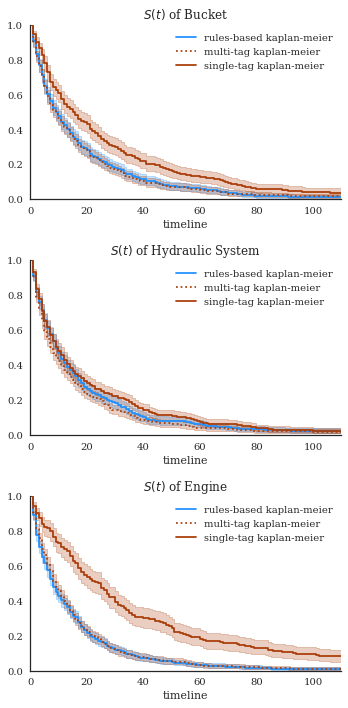

In [30]:

exp = [bucket_exp, eng_exp, hyd_exp]
f,axes = plt.subplots(nrows=3, figsize=(5,10))
for n, ax in enumerate(axes): 
    exp[n]['rules-based']['kmf'].plot(ax=ax, color='dodgerblue')
    exp[n]['multi-tag']['kmf'].plot(ax=ax, color='xkcd:rust', ls=':')
    exp[n]['single-tag']['kmf'].plot(ax=ax, color='xkcd:rust')
    
    ax.set_xlim(0,110)
    ax.set_ylim(0,1)
    ax.set_title(r"$S(t)$"+f" of {res.index.levels[0][n]}")
    sns.despine()
plt.tight_layout()
f.savefig('bkt_KMsurvival.png')   

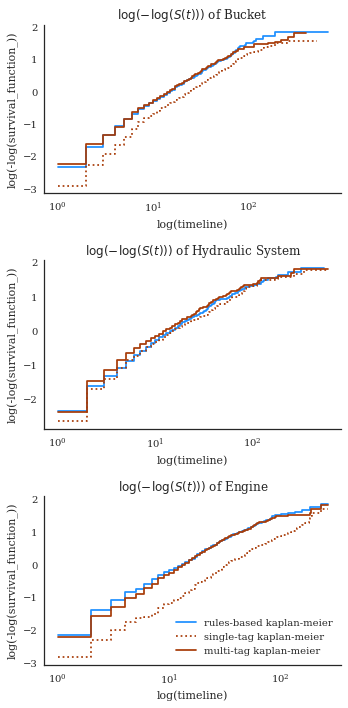

In [38]:
f,axes = plt.subplots(nrows=3, figsize=(5,10))
for n, ax in enumerate(axes): 
    exp[n]['rules-based']['kmf'].plot_loglogs(ax=ax, c='dodgerblue')
    exp[n]['single-tag']['kmf'].plot_loglogs(ax=ax, c='xkcd:rust', ls=':')
    exp[n]['multi-tag']['kmf'].plot_loglogs(ax=ax, c='xkcd:rust')
    if n != 2:
        ax.legend_.remove()
#     ax.set_xlim(0,110)
#     ax.set_ylim(0,1)
    ax.set_title(r"$\log(-\log(S(t)))$"+f" of {res.index.levels[0][n]}")
    sns.despine()
plt.tight_layout()
f.savefig('bkt_logKMsurvival.png')
# kmf.plot_loglogs()

## END ANALYSIS

9.0

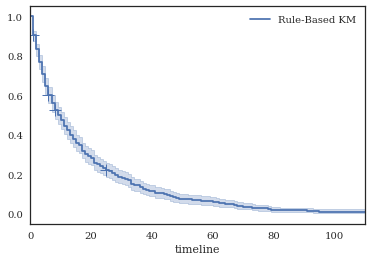

In [34]:
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E, label='Rule-Based KM')
# kmf.survival_function_.plot()
kmf.plot(show_censors=True)
plt.xlim(0,110)
kmf.median_

MTTF: 
Weib 	 10.77
KM 	9.00


/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


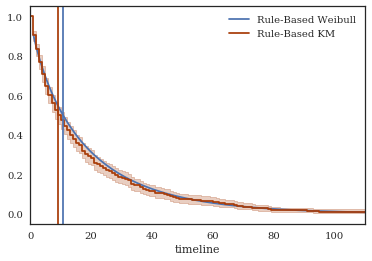

In [38]:
f,ax = plt.subplots()
wf.survival_function_.plot(ax=ax)
kmf.plot(ax=ax, color='xkcd:rust')
ax.axvline(wf.median_)
ax.axvline(kmf.median_, color='xkcd:rust')
ax.set_xlim(0,110)
print(f'MTTF: \nWeib \t {wf.median_:.2f}\nKM \t{kmf.median_:.2f}')

In [36]:
wf.survival_function_at_times(30)

0.19672108202105731

### Tag-Based

In [37]:
df.sort_values('BscStartDate').head(10)

,BscStartDate,Asset,OriginalShorttext,PMType,Cost
4331,2001-07-05,B,replace lhs track adjuster & acumulator,PM01,6169.05
7,2001-07-12,B,REPLACE MISSING LIP TIPS,PM01,1281.36
8,2001-07-19,B,REPLACE LIP,PM01,1251.52
1237,2001-07-19,B,REPLACE FUEL SOLENOID,PM01,222.17
3700,2001-08-08,B,re-mount grease tank,PM01,0.00
2810,2001-08-08,B,re-mount grease tank,PM01,0.00
643,2001-08-13,B,scope wter leak on rhs engine,PM01,0.00
5252,2001-08-13,B,check air con (blowing hot air),PM01,0.00
3935,2001-08-14,B,boom control valve lines & fittings leak,PM01,0.00
1819,2001-08-29,B,REPAIR HYD LEAKS ON TRACK TENSIONERS,PM01,0.00


0.038 0.833
n=373, number of events=351

          coef  se(coef)  lower 0.95  upper 0.95
lambda_ 0.0376    0.0025      0.0327      0.0425
rho_    0.8334    0.0321      0.7704      0.8964
transform: β=0.83	η=26.59


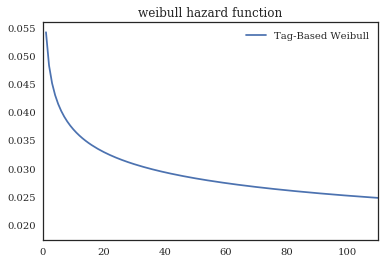

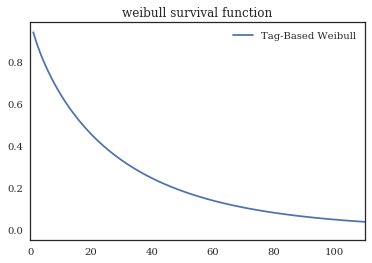

In [39]:
# from lifelines import WeibullFitter, ExponentialFitter, KaplanMeierFitter
# mask = (tag_df.I['bucket']>0)|(tag_df.I['tooth']>0)|(tag_df.I['lip']>0)
# mask = tag_df.I[['bucket', 'tooth', 'lip', 'pin']].sum(axis=1)>0
mask = tag_df.I[['bucket']].sum(axis=1)>0
# mask=df_clean.index
def mask_to_ETraw(df_clean, mask, fill_null=1.):
    filter_df = df_clean.loc[mask]
    g = filter_df.sort_values('BscStartDate').groupby('Asset')
    T = g['BscStartDate'].transform(pd.Series.diff).dt.days
    T_defined = (T>0.)|T.notna()
    T = T[T_defined]
    # assume censored when parts replaced (changeout)
    E = (~(tag_df.S.changeout>0)).astype(int)[mask]
    E = E[T_defined]
    return T.loc[~((T<=0.)|(T.isna()))], E.loc[~((T<=0.)|(T.isna()))]

T, E = mask_to_ETraw(df, mask)
wfT = WeibullFitter()
wfT.fit(T, E, label='Tag-Based Weibull')
print('{:.3f}'.format(wfT.lambda_), '{:.3f}'.format(wfT.rho_))
wfT.print_summary()
wfT.hazard_.plot()
plt.title('weibull hazard function')
plt.xlim(0,110)

wfT.survival_function_.plot()
plt.xlim(0,110)
plt.title('weibull survival function')
print(f'transform: β={wfT.rho_:.2f}\tη={1/wfT.lambda_:.2f}')

15.0

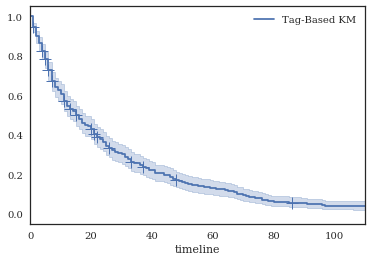

In [40]:
kmfT = KaplanMeierFitter()
kmfT.fit(T, event_observed=E, label='Tag-Based KM')
# kmf.survival_function_.plot()
kmfT.plot(show_censors=True)
plt.xlim(0,110)
kmfT.median_

MTTF: 
Weib 	 17.13
KM 	15.00


/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


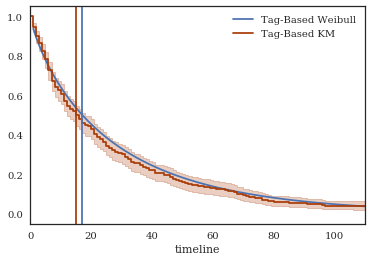

In [41]:
f,ax = plt.subplots()
wfT.survival_function_.plot(ax=ax)
kmfT.plot(ax=ax, color='xkcd:rust')
ax.axvline(wfT.median_)
ax.axvline(kmfT.median_, color='xkcd:rust')
ax.set_xlim(0,110)
print(f'MTTF: \nWeib \t {wfT.median_:.2f}\nKM \t{kmfT.median_:.2f}')

In [42]:
wfT.survival_function_at_times(30)

0.330904116789351

### Comparison

/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


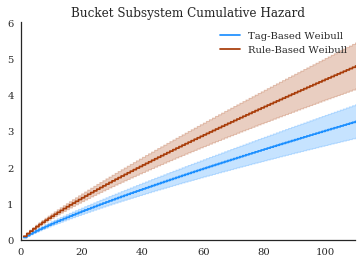

In [44]:
# with sns.axes_style(style='ticks') as style,\
#     sns.plotting_context(context='notebook') as context:
f,ax = plt.subplots()
wfT.plot(ax=ax, color='dodgerblue')
wf.plot(ax=ax, color='xkcd:rust')
ax.set_xlim(0,110)
ax.set_ylim(0,6)
ax.set_title("Bucket Subsystem Cumulative Hazard")
sns.despine()
f.savefig('bkt_WeibCumHaz.png')

/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


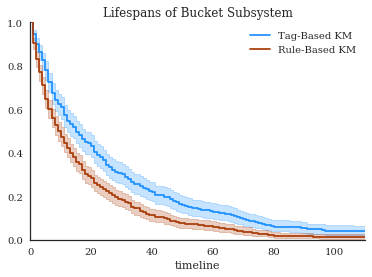

In [46]:

# with sns.axes_style('ticks') as style,\
#     sns.plotting_context(context='paper') as context:
f,ax = plt.subplots()
kmfT.plot(ax=ax, color='dodgerblue')
kmf.plot(ax=ax, color='xkcd:rust')
ax.set_xlim(0,110)
ax.set_ylim(0,1)
ax.set_title("Lifespans of Bucket Subsystem")
sns.despine()
#     f.savefig('bkt_KMsurvival.png')
#     plt.rc('text', usetex=True)
#     plt.rc('font', family='serif')
    

This next one give you an idea of the differences better. using a log-transform. the tags under-estimate death rates a little in the 80-130 day range, probably because there's a failure mode not captured by the [bucket, lip, tooth] tags (because it's rare).

In [435]:

with sns.axes_style(style='ticks') as style,\
    sns.plotting_context(context='notebook') as context:
    f,ax = plt.subplots()
    kmfT.plot_loglogs(ax=ax, color='dodgerblue')
    kmf.plot_loglogs(ax=ax, color='xkcd:rust')
#     ax.set_xlim(0,110)
#     ax.set_ylim(0,1)
    ax.set_title("Lifespans of Bucket Subsystem")
    sns.despine()
    f.savefig('bkt_logKMsurvival.png')

/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


RuntimeError: latex was not able to process the following string:
b'log(-log(survival_function_))'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.16 (TeX Live 2015/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/tbsexton/.cache/matplotlib/tex.cache/b2ee80a80d5642984e3947368dd95c8e.te
x
LaTeX2e <2016/02/01>
Babel <3.9q> and hyphenation patterns for 81 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./b2ee80a80d5642984e3947368dd95c8e.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 ...0}{13.750000}{\sffamily log(-log(survival_
                                                  function_))}
No pages of output.
Transcript written on b2ee80a80d5642984e3947368dd95c8e.log.




Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f4d33d9fd08> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'log(-log(survival_function_))'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.16 (TeX Live 2015/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/tbsexton/.cache/matplotlib/tex.cache/b6984e2413cda899ca76761f24d992f9.te
x
LaTeX2e <2016/02/01>
Babel <3.9q> and hyphenation patterns for 81 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./b6984e2413cda899ca76761f24d992f9.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 ...0}{13.750000}{\rmfamily log(-log(survival_
                                                  function_))}
No pages of output.
Transcript written on b6984e2413cda899ca76761f24d992f9.log.




RuntimeError: latex was not able to process the following string:
b'log(-log(survival_function_))'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.16 (TeX Live 2015/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/tbsexton/.cache/matplotlib/tex.cache/b6984e2413cda899ca76761f24d992f9.te
x
LaTeX2e <2016/02/01>
Babel <3.9q> and hyphenation patterns for 81 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./b6984e2413cda899ca76761f24d992f9.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 ...0}{13.750000}{\rmfamily log(-log(survival_
                                                  function_))}
No pages of output.
Transcript written on b6984e2413cda899ca76761f24d992f9.log.




<Figure size 432x288 with 1 Axes>

In [31]:
kmfT.subtract(kmf)

,Rule-Based KM,Tag-Based KM
timeline,,
0.0,NaN,NaN
1.0,NaN,NaN
2.0,NaN,NaN
3.0,NaN,NaN
4.0,NaN,NaN
5.0,NaN,NaN
6.0,NaN,NaN
7.0,NaN,NaN
8.0,NaN,NaN


## Tag Cool Stuff

In [43]:
colors = {
            'P':'#C0504D',
            'S':'#7ABC32',
            'I':'#4F81BD',
            'U':'#ffc000',
            'NA':'gray',
            'X':'black'
        }

/home/tbsexton/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


<Figure size 864x720 with 0 Axes>

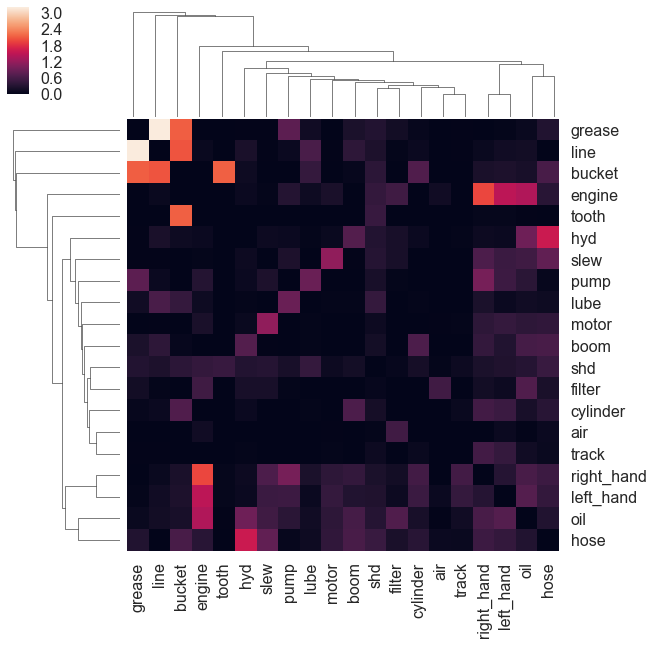

In [54]:
tag_similarity = mlp.tree.node_adj_mat(tag_df["I"])
with sns.axes_style('whitegrid') as style,\
sns.plotting_context('poster') as context:
    plt.figure(figsize=(12,10))
    sns.clustermap(200*tag_similarity.iloc[:20,:20], square=True)

In [57]:
from networkx.algorithms.traversal.depth_first_search import dfs_tree, dfs_successors
D = mlp.tree.heymann_taxonomy(tag_similarity, dynamic=False, verbose=True, tau=1e-3)

 51%|█████▏    | 163/317 [00:00<00:00, 802.99it/s] 

engine


100%|██████████| 317/317 [00:00<00:00, 482.61it/s]

engine
['bolts', 'text', 'rf', 'rear', 'cover', 'sensor', 'new', 'scv', 'lower', 'plate', 'handrail', 'outer', 'sender', 'pressuriser', 'welding', 'bracket', 'cap', 'labor', 'compressor', 'scope', 'machine', 'link', 'wire', 'wiper', 'tube', 'manifold', 'gear', 'inner', 'screen', 'safety', 'swing', 'solenoid', 'handle', 'gasket', 'frame', 'breather', 'lever', 'press', 'air_conditioning', 'ladder', 'joystick', 'deck', 'supply', 'plug', 'electrical', 'hour', 'cavity', 'spline', 'dipstick', 'area', 'rock', 'mcv', 'fitter', 'unit', 'p1', 'head', 'keeper', 'undercarriage', 'accident', 'operator', 'pilot', 'cw', 'rod', 'wing', 'harness', 'walkway', 'shaft', 'bung', 'center', 'arm', 'cost', 'cable', 'foot', 'shovel', 'inside', 'hinge', 'suppression', 'assy', 'chain', 'room', 'thermostat', '08', 'float', '09', 'glass', 'vent', 'bcs', 'pulley', 'rope', 'gland', 'support', 'cummins', 'package', 'directional', 'p3', 'injector', 'windscreen', 'card', 'limit', 'pivot', 'relay', 'car', 'spare', 'cabi

7


/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


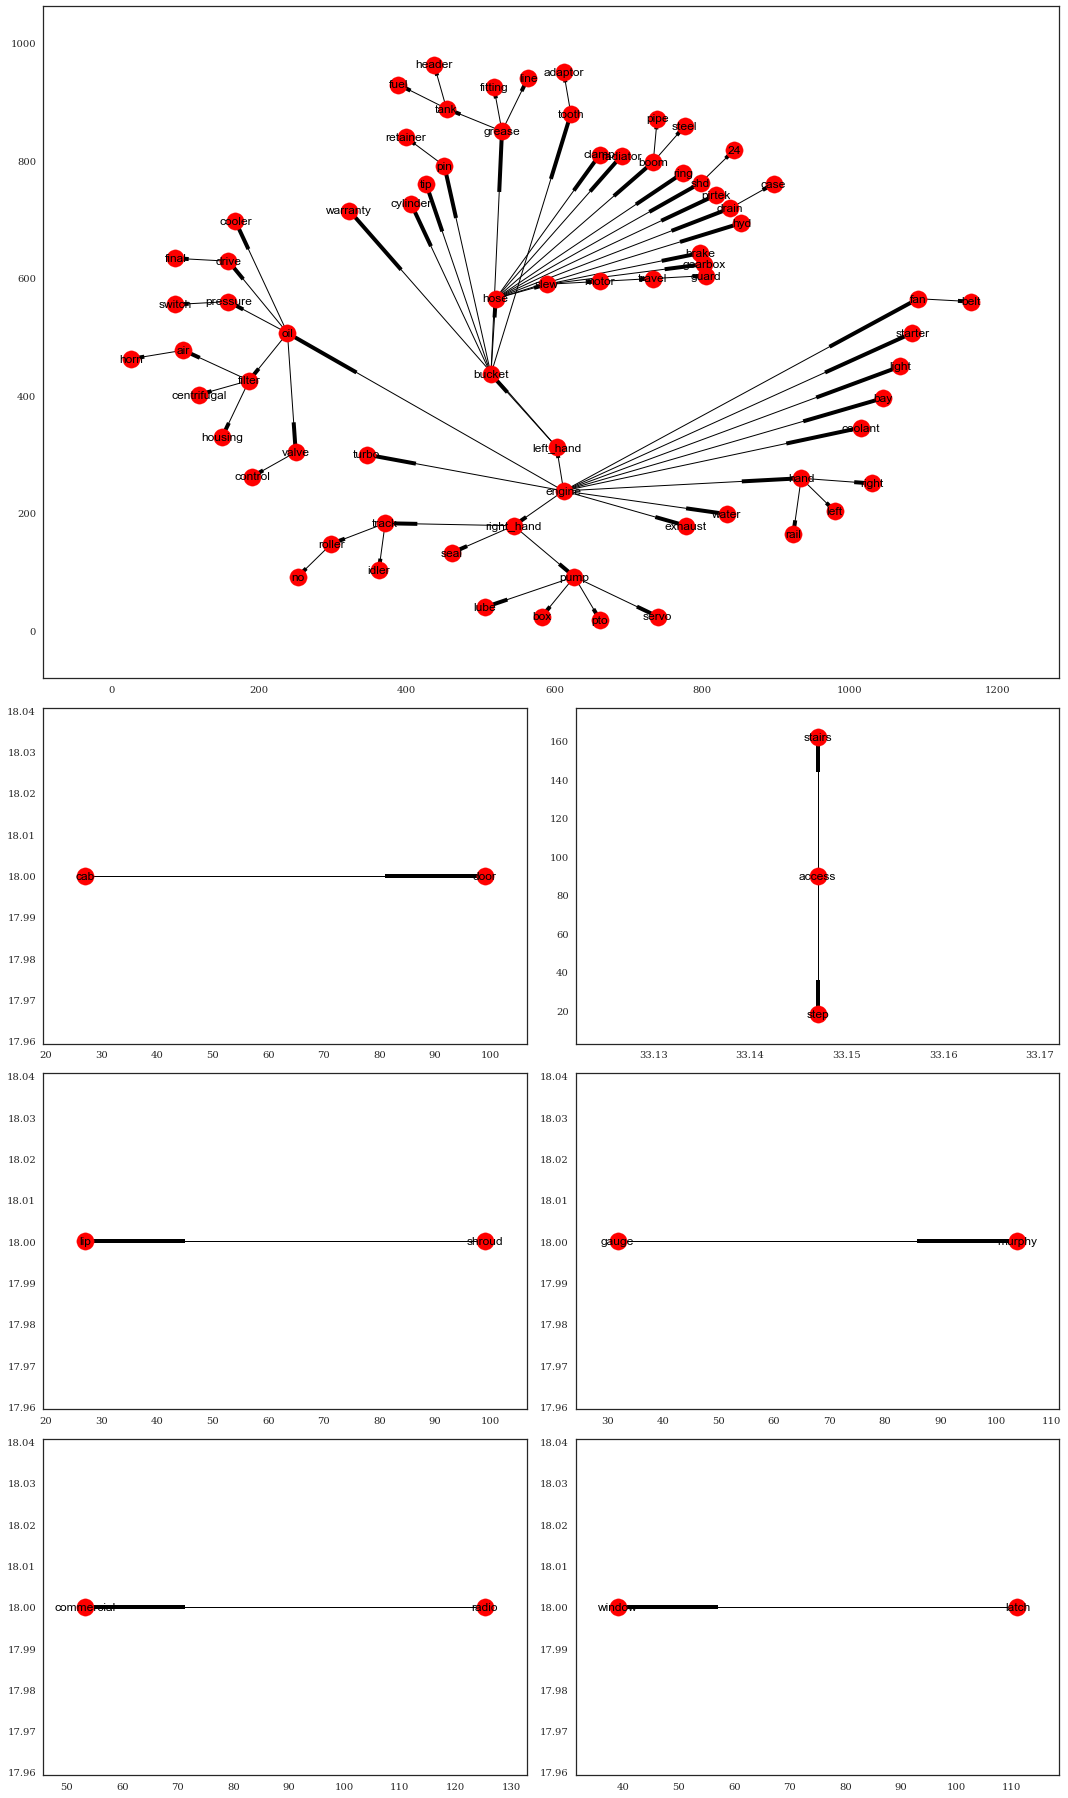

In [58]:
import matplotlib.gridspec as gridspec


subg = list(nx.weakly_connected_component_subgraphs(D))
fig = plt.figure(tight_layout=True, figsize=(15,30))
n_rows = 1+len(subg)//2+len(subg)%2
print(len(subg))
gs = gridspec.GridSpec(n_rows, 2, 
                       height_ratios=[2]+(n_rows-1)*[1])

for n, d in enumerate(subg):
    if n==0:
        ax = fig.add_subplot(gs[:n+1, :])
    else:
        ax = fig.add_subplot(gs[(n+1)//2, (n+1)%2])
    nx.draw_networkx(d, pos=nx.drawing.nx_pydot.pydot_layout(d, prog='twopi'), ax=ax)

/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


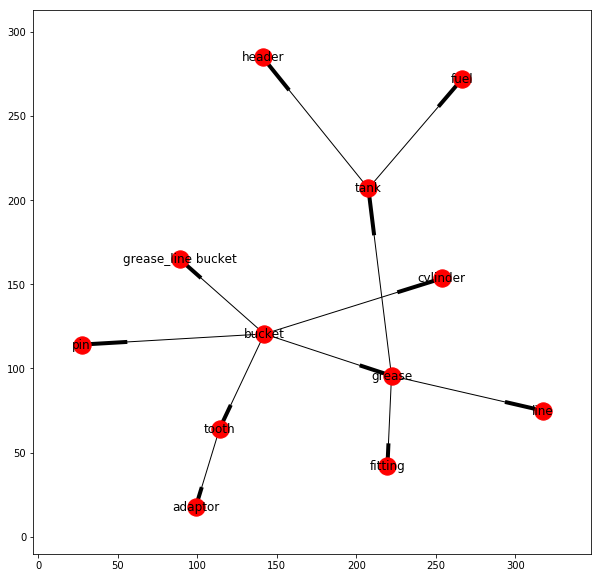

In [36]:

subD = dfs_tree(D, 'bucket')

plt.figure(figsize=(10,10))
nx.draw_networkx(subD, pos=nx.drawing.nx_pydot.pydot_layout(subD, prog='fdp'))

/home/tbsexton/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


<Figure size 864x720 with 0 Axes>

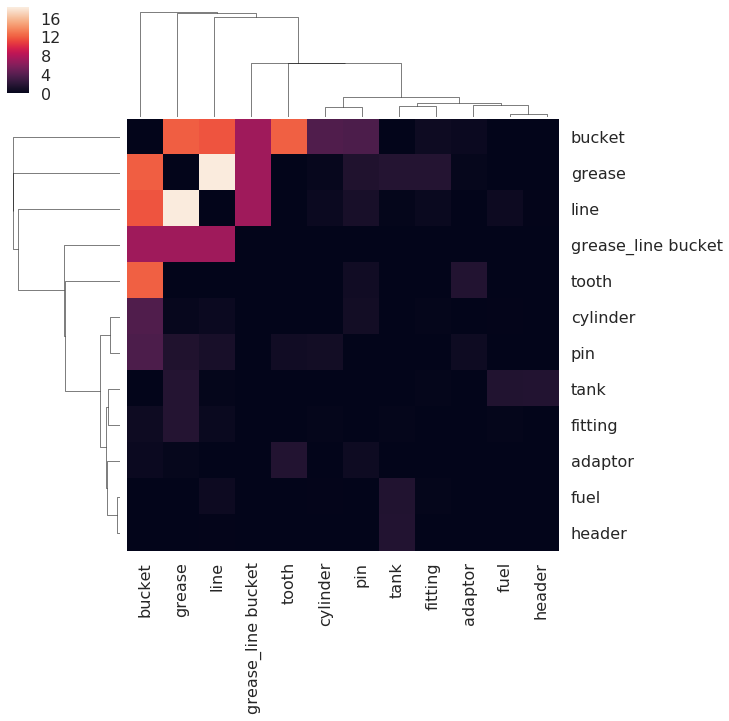

In [37]:
subsys_similarity = mlp.tree.node_adj_mat(tag_df.I[subD.nodes()])
with sns.axes_style('whitegrid') as style,\
sns.plotting_context('poster') as context:
    plt.figure(figsize=(12,10))
    sns.clustermap(200*subsys_similarity, square=True)

0.101 0.879
n=1020, number of events=984

          coef  se(coef)  lower 0.95  upper 0.95
lambda_ 0.1008    0.0039      0.0933      0.1083
rho_    0.8793    0.0192      0.8417      0.9169
transform: β=0.88	η=9.92
MTTF: 
Weib 	 6.54
KM 	6.00


/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


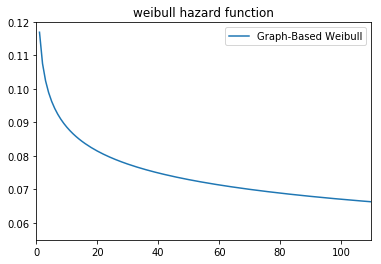

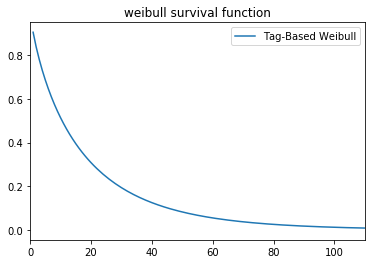

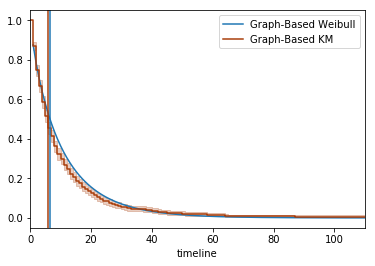

In [38]:
# tag_df.I[subD.nodes()].sum(axis=1)>0
# mask = tag_df.I[subD.nodes()].sum(axis=1)>0
mask = tag_df.I[list(nx.all_neighbors(D, 'bucket'))].sum(axis=1)>0

T, E = mask_to_ETraw(df, mask)
wfG = WeibullFitter()
wfG.fit(T, E, label='Graph-Based Weibull')
print('{:.3f}'.format(wfG.lambda_), '{:.3f}'.format(wfG.rho_))
wfG.print_summary()
wfG.hazard_.plot()
plt.title('weibull hazard function')
plt.xlim(0,110)

wfT.survival_function_.plot()
plt.xlim(0,110)
plt.title('weibull survival function')
print(f'transform: β={wfG.rho_:.2f}\tη={1/wfG.lambda_:.2f}')

kmfG = KaplanMeierFitter()
kmfG.fit(T, event_observed=E, label='Graph-Based KM')

f,ax = plt.subplots()
wfG.survival_function_.plot(ax=ax)
kmfG.plot(ax=ax, color='xkcd:rust')
ax.axvline(wfG.median_)
ax.axvline(kmfG.median_, color='xkcd:rust')
ax.set_xlim(0,110)
print(f'MTTF: \nWeib \t {wfG.median_:.2f}\nKM \t{kmfG.median_:.2f}')

/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


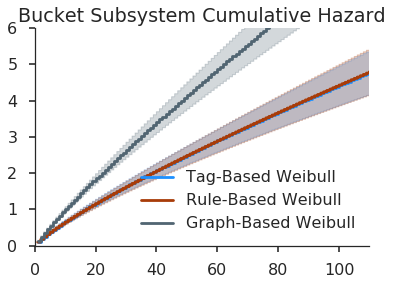

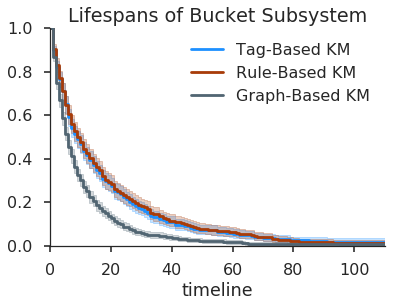

In [39]:
with sns.axes_style(style='ticks') as style,\
    sns.plotting_context(context='poster') as context:
    f,ax = plt.subplots()
    wfT.plot(ax=ax, color='dodgerblue')
    wf.plot(ax=ax, color='xkcd:rust')
    wfG.plot(ax=ax, color='xkcd:slate')
    ax.set_xlim(0,110)
    ax.set_ylim(0,6)
    ax.set_title("Bucket Subsystem Cumulative Hazard")
    sns.despine()
    

with sns.axes_style(style='ticks') as style,\
    sns.plotting_context(context='poster') as context:
    f,ax = plt.subplots()
    kmfT.plot(ax=ax, color='dodgerblue')
    kmf.plot(ax=ax, color='xkcd:rust')
    kmfG.plot(ax=ax, color='xkcd:slate')
    ax.set_xlim(0,110)
    ax.set_ylim(0,1)
    ax.set_title("Lifespans of Bucket Subsystem")
    sns.despine()

In [59]:
from networkx.readwrite import json_graph

import json

subD = dfs_tree(D, 'right_hand')

with open('d3tree.json', 'w') as outfile:
    s=json.dump(json_graph.tree.tree_data(subD, 'right_hand'), outfile)

In [60]:
%%writefile f2.template
<!DOCTYPE html>
<meta charset="utf-8">
<style>

.node {
  cursor: pointer;
}

.node circle {
  fill: #fff;
  stroke: steelblue;
  stroke-width: 1.5px;
}

.node text {
  font: 10px sans-serif;
}

.link {
  fill: none;
  stroke: #ccc;
  stroke-width: 1.5px;
}

</style>
<body>
<script src="//d3js.org/d3.v3.min.js"></script>
<script>

var margin = {top: 20, right: 120, bottom: 20, left: 120},
    width = 1400 - margin.right - margin.left,
    height = 900 - margin.top - margin.bottom;

var i = 0,
    duration = 750,
    root;

var tree = d3.layout.tree()
    .size([height, width]);

var diagonal = d3.svg.diagonal()
    .projection(function(d) { return [d.y, d.x]; });

var svg = d3.select("body").append("svg")
    .attr("width", width + margin.right + margin.left)
    .attr("height", height + margin.top + margin.bottom)
  .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

d3.json("d3tree.json", function(error, flare) {
  if (error) throw error;

  root = flare;
  root.x0 = height / 2;
  root.y0 = 0;

  function collapse(d) {
    if (d.children) {
      d._children = d.children;
      d._children.forEach(collapse);
      d.children = null;
    }
  }

  root.children.forEach(collapse);
  update(root);
});

d3.select(self.frameElement).style("height", "1200px");

function update(source) {

  // Compute the new tree layout.
  var nodes = tree.nodes(root).reverse(),
      links = tree.links(nodes);

  // Normalize for fixed-depth.
  nodes.forEach(function(d) { d.y = d.depth * 180; });

  // Update the nodes…
  var node = svg.selectAll("g.node")
      .data(nodes, function(d) { return d.id || (d.id = ++i); });

  // Enter any new nodes at the parent's previous position.
  var nodeEnter = node.enter().append("g")
      .attr("class", "node")
      .attr("transform", function(d) { return "translate(" + source.y0 + "," + source.x0 + ")"; })
      .on("click", click);

  nodeEnter.append("circle")
      .attr("r", 1e-6)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeEnter.append("text")
      .attr("x", function(d) { return d.children || d._children ? -10 : 10; })
      .attr("dy", ".35em")
      .attr("text-anchor", function(d) { return d.children || d._children ? "end" : "start"; })
      .text(function(d) { return d.id; })
      .style("fill-opacity", 1e-6);

  // Transition nodes to their new position.
  var nodeUpdate = node.transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + d.y + "," + d.x + ")"; });

  nodeUpdate.select("circle")
      .attr("r", 4.5)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeUpdate.select("text")
      .style("fill-opacity", 1);

  // Transition exiting nodes to the parent's new position.
  var nodeExit = node.exit().transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + source.y + "," + source.x + ")"; })
      .remove();

  nodeExit.select("circle")
      .attr("r", 1e-6);

  nodeExit.select("text")
      .style("fill-opacity", 1e-6);

  // Update the links…
  var link = svg.selectAll("path.link")
      .data(links, function(d) { return d.target.id; });

  // Enter any new links at the parent's previous position.
  link.enter().insert("path", "g")
      .attr("class", "link")
      .attr("d", function(d) {
        var o = {x: source.x0, y: source.y0};
        return diagonal({source: o, target: o});
      });

  // Transition links to their new position.
  link.transition()
      .duration(duration)
      .attr("d", diagonal);

  // Transition exiting nodes to the parent's new position.
  link.exit().transition()
      .duration(duration)
      .attr("d", function(d) {
        var o = {x: source.x, y: source.y};
        return diagonal({source: o, target: o});
      })
      .remove();

  // Stash the old positions for transition.
  nodes.forEach(function(d) {
    d.x0 = d.x;
    d.y0 = d.y;
  });
}

// Toggle children on click.
function click(d) {
  if (d.children) {
    d._children = d.children;
    d.children = null;
  } else {
    d.children = d._children;
    d._children = null;
  }
  update(d);
}

</script>

Overwriting f2.template


In [61]:
from IPython.display import IFrame
import re

def replace_all(txt,d):
    rep = dict((re.escape('{'+k+'}'), str(v)) for k, v in d.items())
    pattern = re.compile("|".join(rep.keys()))
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], txt)    

count=0
def serve_html(s,w,h):
    import os
    global count
    count+=1
    fn= '__tmp'+str(os.getpid())+'_'+str(count)+'.html'
    with open(fn,'w') as f:
        f.write(s)
    return IFrame('files/'+fn,w,h)

def f2(w=500,h=400):
    d={
       'width'      :w,
       'height'     :h,
       }
    with open('f2.template','r') as f:
        s=f.read()
    s= replace_all(s,d)        
    return serve_html(s,w+30,h+30)

In [62]:
f2(w=1500,h=1200)